In [1]:
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from msresist.comp_estimator import ComHyperPar, MyOwnKMEANS
from msresist.plsr import ClusterAverages, GridSearch_CV, MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.pre_processing import preprocessing, MergeDfbyMean, FoldChangeFilter
from msresist.sequence_analysis import GeneratingKinaseMotifs
import scipy as sp, numpy as np, pandas as pd, math
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns; sns.set(color_codes=True)
from FileExporter import create_download_link
from Bio import SeqIO
import warnings
warnings.simplefilter("ignore")

# Importing and pre-processing data

### Phosphorylation levels of peptides across conditions | X Matrix where peptides = vars and conditions = obs

Preprocessing: Each peptide is mean-centered across conditions, merged, converted to fold-change to the control, and log2-transformed. Data can be merged by raw sequences or mapped motifs.

In [3]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

treatments = A_r.columns[2:]
header = A_r.columns

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=False, FCfilter=True, log2T=True)

In [4]:
print(ABC_mc.shape)
ABC_mc

(994, 12)


,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,tTILyk,(blank),0.0,-0.402589,-0.371230,-1.071370,-0.311635,-0.750077,-0.636763,-0.630097,-0.494944,-0.580763
1,yIEIFR,(blank),0.0,-0.160277,0.251311,0.262527,-0.334819,-0.655114,-0.082942,-0.759590,0.615606,0.440143
2,PGFyVEANPMPTFk,"1-phosphatidylinositol 4,5-bisphosphate phosph...",0.0,-1.023900,-0.382972,-1.322835,-0.899760,-0.553113,-1.372936,-1.605112,-0.344332,-1.411142
3,LLPEYGGtk,"10 kDa heat shock protein, mitochondrial",0.0,0.924837,0.305843,-0.347504,0.186489,0.693420,0.605297,0.613979,1.002997,-0.397516
4,LLPEyGGTk,"10 kDa heat shock protein, mitochondrial",0.0,-0.233022,-0.070428,-0.455357,-0.386191,-0.087726,-0.346121,-0.040792,0.105028,0.148458
5,yLAEFATGNDR,14-3-3 protein epsilon,0.0,0.207012,-0.060764,-0.705088,-0.290539,-0.196740,-0.245622,-0.999678,-0.808844,-1.032461
6,LLSVAyk,14-3-3 protein zeta/delta,0.0,-0.408363,-0.727275,-2.597457,-2.741500,-2.760543,-2.819845,-2.790966,-2.602876,-2.837017
7,sPsQDFSFIEDTEILDSAMYR,182 kDa tankyrase-1-binding protein,0.0,0.519040,0.112672,0.645260,0.943389,0.353341,0.767531,1.036100,1.147313,2.366592
8,yVEIER,26S proteasome non-ATPase regulatory subunit 12,0.0,-0.486505,-0.425736,-0.641646,-0.325606,-0.296010,-0.412718,-0.680073,-0.378490,-0.342905
9,GGGMPGLGQGPPTDAPAVDTAEQVyISSLALLk,26S proteasome non-ATPase regulatory subunit 14,0.0,0.291634,0.414042,0.256048,0.139467,0.110760,0.261981,0.687572,0.779318,0.030420


In [5]:
Xf_data = ABC_mc.iloc[:,2:].T
Xf_protnames = list(ABC_mc.iloc[:,1])
Xf_seqs = list(ABC_mc.iloc[:,0])

### Phenotypes

Cell Viability:

In [6]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/viability.csv')
Y_cv = Y_cv.iloc[:10, 2]

## Phosphopeptides Heat Map

In [7]:
# g = sns.clustermap(Xf_data.iloc[:, 2:].copy().T, method = "average", robust = True)
# g

In [8]:
# Xf.iloc[:, 2:] = np.log2(Xf.iloc[:, 2:].values)
# Xf_data = np.log2(Xf_data.values)

In [9]:
# p = g.dendrogram_row.reordered_ind

Recovering heat map peptides 

In [10]:
# p = g.dendrogram_row.reordered_ind

# hm_prots = []
# for i in p:
#     hm_prots.append(Xf.iloc[i,:])
# hm_prots = pd.DataFrame(hm_prots)

## Cell Viability Measurements

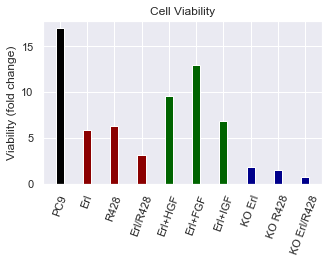

In [11]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.bar(np.linspace(1,10,10)-1, Y_cv,width=0.3,align='center', color=['black', 'darkred', 'darkred', 'darkred', 'darkgreen', 'darkgreen', 'darkgreen', 'darkblue', 'darkblue', 'darkblue'])
plt.xticks(np.arange(10), (treatments), rotation=70)
plt.title("Cell Viability")
plt.ylabel("Viability (fold change)")
# plt.savefig("CellViability.pdf")
plt.show()

# GridSearchCV

Simultaneous hyperparameter tuning of number of clusters and components across entire model pipeline

In [12]:
# import warnings
# warnings.simplefilter("ignore")

# CVresults_max, CVresults_min, best_params = ComHyperPar(Xf_data, Y_cv, Xf_protnames, Xf_seqs)

In [13]:
# print(best_params)
# display(CVresults_min.iloc[:20,:])
# create_download_link(CVresults_min, "GridSearch_ClustVsComp")

In [14]:
# MSE = np.abs(CVresults_min.iloc[:20, 2])
#range_ = np.linspace(1,MSE.shape[0],MSE.shape[0])

#fig, axs = plt.subplots(1,1,figsize=(7,5))
#plt.setp(axs, xticks=range_)
#plt.bar(range_,MSE,width=0.3,align='center', color = "green")
# plt.savefig("GridSearch_Cl&Comp.pdf")
#plt.title("GridSearch Cell Viability")
#plt.xlabel("Number of Components")
#plt.ylabel("MSE")
#plt.show()

# R2Y / Q2Y

Percentages of variance explained (R2Y) and predicted (Q2Y) across numbers of components

In [15]:
import warnings
warnings.simplefilter("ignore")

maxComp = 10
Q2Y = Q2Y_across_components(Xf_data, Y_cv, maxComp+1)
R2Y = R2Y_across_components(Xf_data, Y_cv, maxComp+1)

First using the entire data set

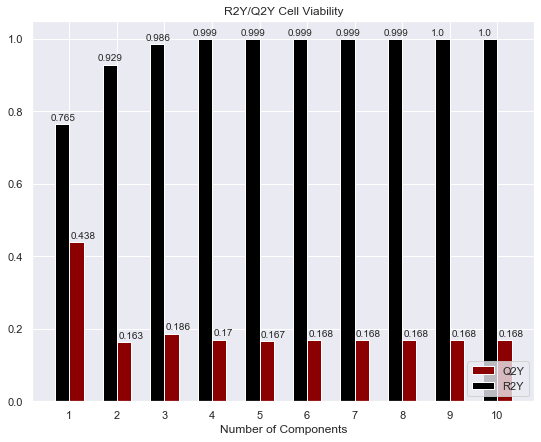

In [16]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.01,3)
disp_values(R2Y,0.6,0.01,3)

Then after k-means clustering setting the number of clusters to 5

In [17]:
kmeans = MyOwnKMEANS(5, Xf_protnames, Xf_seqs).fit(Xf_data, Y=None)
centers = kmeans.transform(Xf_data)
clustermembers = kmeans.ClusterMembers(Xf_data)

In [18]:
maxComp = centers.shape[1]
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp)
R2Y = R2Y_across_components(centers, Y_cv, maxComp)

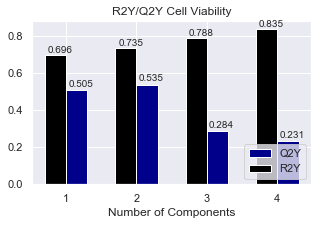

In [19]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp-1,maxComp-1)

fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)
# plt.savefig("R2YQ2Y_BR1_5Cl.pdf")

# Building chained k-means and PLSR model pipeline

## Measured Vs Predicted

We've learnt during cross-validation that by setting the number of components to 2 and the number of clusters to 5 the model should perform reasonably well at predicting the viability response across conditions. To corroborate that we plot measured vs predicted below. We also show that the model performs better after clustering than using the entire data set, or even the filtered data set. 

In [20]:
ncl, ncomp = 5, 2
estimators = [('kmeans', MyOwnKMEANS(ncl, Xf_protnames, Xf_seqs)), ('plsr', PLSRegression(ncomp))]
pipe = Pipeline(estimators)

In [21]:
X_scores, Y_scores = pipe.fit_transform(Xf_data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = pipe.named_steps.plsr.x_loadings_[:, 0], pipe.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = pipe.named_steps.plsr.y_loadings_[:, 0], pipe.named_steps.plsr.y_loadings_[:, 1]

### Cross-Validation Strategy 1 - Pipeline:

Pearson's R:  0.7798468117824779 
 p-value:  0.007803408703610202


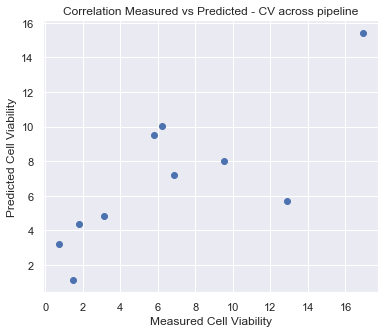

In [22]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(Xf_data,Y_cv, pipe, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
#textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
#props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
#plt.text(0.5, 14.7, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

### Cross-Validation Strategy 2 - Fixed Clusters:

Pearson's R:  0.4772913626934505 
 p-value:  0.1630260712086856


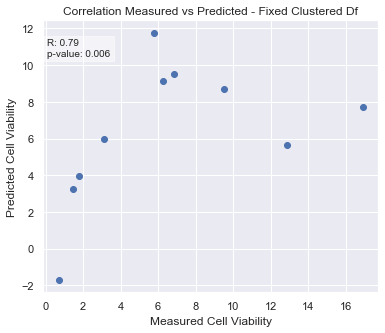

In [23]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(Xf_data,Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Df")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability")
textstr = '\n'.join(['R: 0.79', 'p-value: 0.006'])
props = dict(boxstyle = 'square', facecolor = "white", alpha = 0.5)
plt.text(0.1, 10.5, textstr, bbox=props)
# plt.savefig('Measured_Predict_5cl2co_pipe.pdf')
plt.show()

### Scores and Loadings Plot

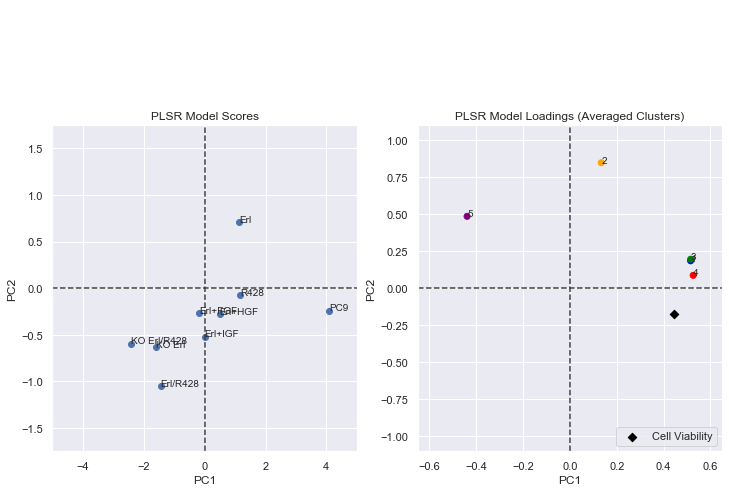

In [24]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
# colors_ = cm.rainbow(np.linspace(0, 1, 5))
colors_ = ["blue", "orange", "green", "red", "purple"]


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-1.75, 1.75])

for i, txt in enumerate(["1", "2", "3", "4", "5"]):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.65, 0.65])
axs[1].set_ylim([-1.1, 1.1])
# plt.savefig('scores_loadings.pdf')
plt.show()

In [25]:
ClusterMembers = pipe.named_steps.kmeans.ClusterMembers(Xf_data)
count = sum(len(v) for v in ClusterMembers.values())
CM_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in ClusterMembers.items() ]))
create_download_link(CM_df, 'fsdf')

In [26]:
CM_df

,1,Seqs_Cluster_1,2,Seqs_Cluster_2,3,Seqs_Cluster_3,4,Seqs_Cluster_4,5,Seqs_Cluster_5
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",PGFyVEANPMPTFk,(blank),yIEIFR,(blank),tTILyk,14-3-3 protein zeta/delta,LLSVAyk,"10 kDa heat shock protein, mitochondrial",LLPEYGGtk
1,Abl interactor 1,TPYktLEPVkPPTVPNDYMTSPAR,"10 kDa heat shock protein, mitochondrial",LLPEyGGTk,14-3-3 protein epsilon,yLAEFATGNDR,"Actin, cytoplasmic 1",EyDESGPSIVHR,182 kDa tankyrase-1-binding protein,sPsQDFSFIEDTEILDSAMYR
2,Abl interactor 2,tLEPVRPPVVPNDyVPSPTR,26S proteasome regulatory subunit 10B,VSSSIVDkyIGESAR,26S proteasome non-ATPase regulatory subunit 12,yVEIER,Adapter molecule crk,EEAEyVR,26S proteasome non-ATPase regulatory subunit 14,GGGMPGLGQGPPTDAPAVDTAEQVyISSLALLk
3,"Actin, cytoplasmic 1",LTDyLmk,40S ribosomal protein SA,DHQPLTEASyVNLPTIALcNTDSPLR,"60 kDa heat shock protein, mitochondrial",YISPyFINTSk,Afadin,yFTFPASk,ADP/ATP translocase 2,yFPTQALNFAFk
4,"Actin, cytoplasmic 1",LyANTVLSGGTTMYPGIADR,"60 kDa heat shock protein, mitochondrial",EFQDAyVLLSEk,ADP-ribosylation factor-like protein 11,tTLLyk,BAG family molecular chaperone regulator 3,tHYPAQQGEYQTHQPVyHk,ARF GTPase-activating protein GIT1,GSGADSDyENTQSGDPLLGLEGk
5,"Actin, cytoplasmic 1",ySFTTTAER,"60 kDa heat shock protein, mitochondrial",QEIIEQLDVTTSEyEkEk,ADP-sugar pyrophosphatase,tLHyEcIVLVk,BAG family molecular chaperone regulator 3,tHYPAQQGEYQtHQPVYHk,ATP-dependent (S)-NAD(P)H-hydrate dehydratase,GVVGGcQEyTGAPYFAAISALk
6,Activated CDC42 kinase 1,SSTHyYLLPERPSYLER,60S acidic ribosomal protein P0,IQLLDDyPk,ARF GTPase-activating protein GIT1,sQSDLDDQHDyDSVAsDEDTDQEPLR,Band 4.1-like protein 2,EGDNIyVR,Abl interactor 1,tLEPVkPPTVPNDyMTSPAR
7,Aldo-keto reductase family 1 member C3,LHYFNSDSFASHPNyPYSDEY,60S acidic ribosomal protein P0,IQLLDDyPkcFIVGADNVGSk,ATPase WRNIP1,GEEHyNcISALHk,Band 4.1-like protein 2,syTLVVAk,Actin-related protein 3C,ITyFIQQLLR
8,Aldose reductase,AIDVGyR,60S acidic ribosomal protein P2,yVASYLLAALGGNSsPSAk,Actin filament-associated protein 1-like 2,AQQPLSLVGcEVVPDPSPDHLYsFR,Brain-specific angiogenesis inhibitor 1-associ...,yDTLSk,Adenylosuccinate lyase,yASPEMcFVFSDR
9,Alpha-actinin-1,TNyTMEHIR,60S ribosomal protein L15,GyVIYR,Actin filament-associated protein 1-like 2,AQQPLSLVGcEVVPDPSPDHLySFR,Catenin delta-1,YEDGYPGGSDNyGSLSR,Brain-specific angiogenesis inhibitor 1-associ...,RPYSVAVPAFSQGLDDyGAR


### Cluster Averages across Conditions

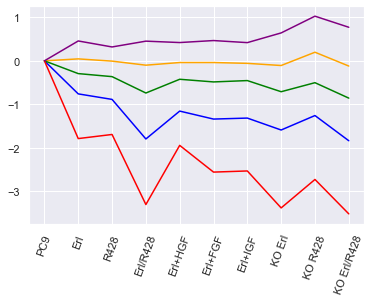

,0,1,2,3,4,5,6,7,8,9
0,0.0,-0.758969,-0.885705,-1.794223,-1.154009,-1.337381,-1.314667,-1.588459,-1.256418,-1.834844
1,0.0,0.044542,-0.006772,-0.099825,-0.038937,-0.038950,-0.057806,-0.107578,0.197692,-0.119890
2,0.0,-0.293304,-0.362876,-0.739085,-0.423475,-0.484425,-0.453471,-0.709208,-0.501889,-0.856186
3,0.0,-1.785281,-1.691051,-3.299635,-1.941316,-2.554925,-2.528906,-3.377466,-2.724171,-3.513839
4,0.0,0.456223,0.318545,0.451947,0.419780,0.465593,0.418089,0.640927,1.025286,0.770741


In [27]:
Centers = pipe.named_steps.kmeans.transform(Xf_data)
memb = pipe.named_steps.kmeans.ClusterMembers(Xf_data)


fig = plt.figure(figsize=(6,4))

colors_ = ["blue", "orange", "green", "red", "purple"]

centersT = np.transpose(Centers)
for i in range(centersT.shape[0]):
    plt.plot(centersT[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.xticks(np.arange(centersT.shape[1]), (treatments), rotation=70)
# plt.legend(loc=2, prop={'size':8})
# plt.savefig("ClAvgAcrossCond_BR1.pdf")
plt.show()
display(pd.DataFrame(centersT))